## Import

In [28]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

## MNIST 데이터를 불러옵니다.

In [6]:
mnist = tf.keras.datasets.mnist

In [76]:
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

In [77]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

**28 X 28 X 1**로 shape를 변경합니다.

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)

x_train을 Normalization 해줍니다. **-1 ~ 1 사이의 값**을 가집니다.

(이는 나중에 마지막 출력층 activation에서 `sigmoid`말고 `tanh`를 사용하기 위함입니다.

In [ ]:
x_train = x_train / 127.5 - 1

In [180]:
x_train.min(), x_train.max()

(-1.0, 1.0)

## Encoder를 정의합니다.

In [45]:
encoder_input = Input(shape=(28, 28, 1))

# 28 X 28
x = Conv2D(32, 3, padding='same')(encoder_input) 
x = BatchNormalization()(x)
x = LeakyReLU()(x) 

# 28 X 28 -> 14 X 14
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU()(x) 

# 14 X 14 -> 7 X 7
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 17 X 7
x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

# 2D 좌표로 표기하기 위하여 2를 출력값으로 지정합니다.
encoder_output = Dense(2)(x)

## Encoder 모델 정의

In [46]:
encoder = Model(encoder_input, encoder_output)

In [47]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_44 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_45 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 14, 14, 64)        0   

## Decoder

In [49]:
# Input으로는 2D 좌표가 들어갑니다.
decoder_input = Input(shape=(2, ))

# 2D 좌표를 7*7*64 개의 neuron 출력 값을 가지도록 변경합니다.
x = Dense(7*7*64)(decoder_input)
x = Reshape( (7, 7, 64))(x)

# 7 X 7 -> 7 X 7
x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 7 X 7 -> 14 X 14
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 14 X 14 -> 28 X 28
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 28 X 28 -> 28 X 28
x = Conv2DTranspose(32, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh')(x)

## Decoder 모델 정의

In [50]:
decoder = Model(decoder_input, decoder_output)

In [51]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_52 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 64)        3692

## Hyperparameter 정의

In [154]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32

## Encoder와 Decoder를 연결합니다.

In [90]:
encoder_in = Input(shape=(28, 28, 1))
x = encoder(encoder_in)
decoder_out = decoder(x)

## Auto Encoder 모델을 최종 정의합니다.

In [91]:
auto_encoder = Model(encoder_in, decoder_out)

## Auto Encoder 모델을 compile 합니다.

optimizer는 `Adam`, loss는 `MSE` 에러를 가지도록 합니다.

In [98]:
auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=tf.keras.losses.MeanSquaredError())

체크포인트를 정의합니다.

In [155]:
checkpoint_path = 'tmp/01-basic-auto-encoder-MNIST.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor='loss', 
                             verbose=1)

학습을 시작합니다.

In [181]:
auto_encoder.fit(x_train, x_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=100, 
                 callbacks=[checkpoint], 
                )

In [161]:
auto_encoder.load_weights(checkpoint_path)

## 시각화

In [156]:
import matplotlib.pyplot as plt

%matplotlib inline

In [158]:
# MNIST 이미지에 대하여 x, y 좌표로 뽑아냅니다.
xy = encoder.predict(x_train)

In [159]:
xy.shape, y_train.shape

((60000, 2), (60000,))

## 인코더의 X, Y 좌표 값을 시각화 해보겠습니다.

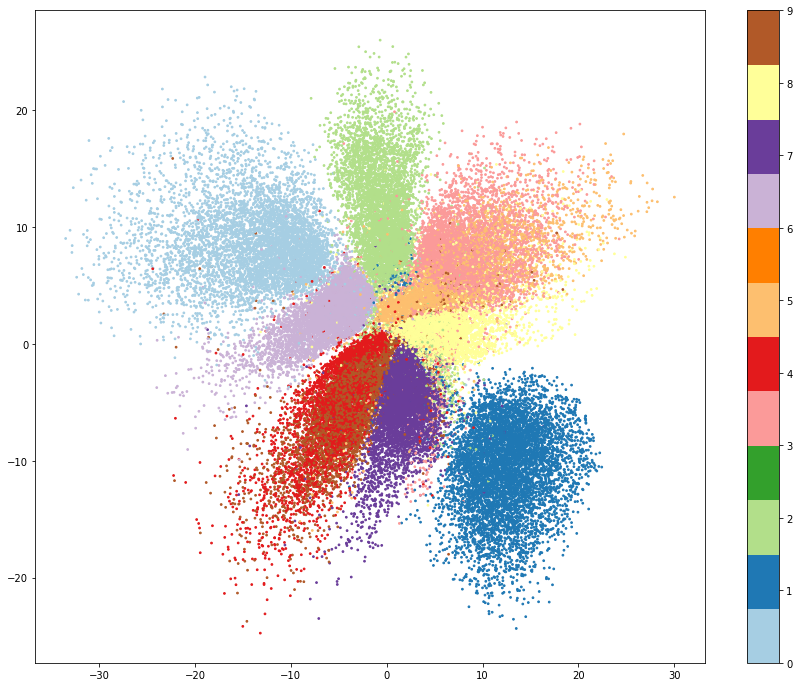

In [160]:
plt.figure(figsize=(15, 12))
plt.scatter(x=xy[:, 0], y=xy[:, 1], c=y_train, cmap=plt.get_cmap('Paired'), s=3)
plt.colorbar()
plt.show()

## Auto Encoder를 통한 이미지 재생성 성능 비교 시각화

In [ ]:
decoded_images = auto_encoder.predict(x_train)

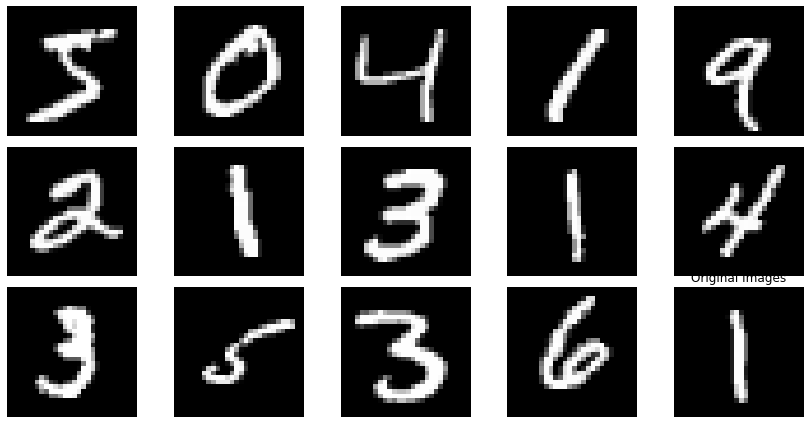

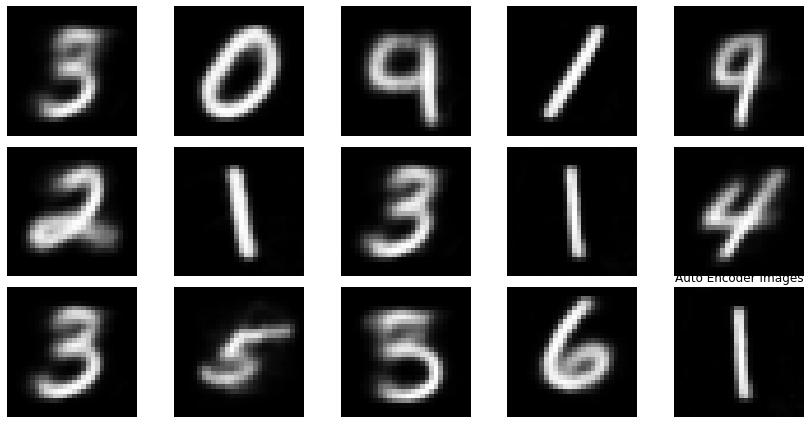

In [179]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Original Images')
plt.show()

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Auto Encoder Images')
plt.show()

**정리**

1. 첫번째 디코딩 된 이미지를 보면, 원본 이미지는 5이나, decoder 이미지는 3처럼 보인다. (3번째도 원래 4인데 9처럼 디코딩 되었다)
2. 전체적으로 이미지 재구성에 대한 성능은 뛰어난 편이다.
3. Decoder만 따로 떼내어, 임의의 X, Y 좌표를 넣어 주는 것으로 이미지를 새로 만들어 낼 수도 있다.